In [16]:
def extract_values(file_path):
    t_values = []
    error_values = []
    seed_values = []

    with open(file_path, 'r') as file:
        for line in file:
            # Strip leading/trailing whitespace characters
            line = line.strip()
            
            # Extract t value
            t_start = line.find('t = ') + len('t = ')
            t_end = line.find(',', t_start)
            if t_start == -1 or t_end == -1:
                continue  # Skip lines that don't have 't'
            t_value_str = line[t_start:t_end].strip()
            try:
                t_value = float(t_value_str)
                t_values.append(t_value)
            except ValueError:
                continue  # Skip lines where 't' cannot be converted to float

            # Extract error value
            error_start = line.find('error = ') + len('error = ')
            if error_start == -1:
                continue  # Skip lines that don't have 'error'
            error_value_str = line[error_start:].strip()
            try:
                error_value = float(error_value_str)
                error_values.append(error_value)
            except ValueError:
                continue  # Skip lines where 'error' cannot be converted to float

            # Extract seed value
            seed_start = line.find('seed = ') + len('seed = ')
            seed_end = line.find(',', seed_start)
            if seed_start == -1 or seed_end == -1:
                continue  # Skip lines that don't have 'seed'
            seed_value_str = line[seed_start:seed_end].strip()
            try:
                seed_value = int(seed_value_str)
                seed_values.append(seed_value)
            except ValueError:
                continue  # Skip lines where 'seed' cannot be converted to int

    return t_values, error_values, seed_values


In [17]:
import matplotlib.pyplot as plt
from math import log2
import statistics as stat
import numpy as np
import scipy.stats

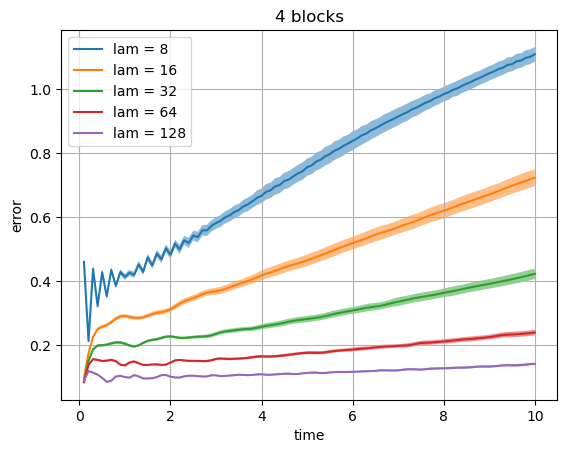

In [20]:
for lamb in [8,16,32,64,128]:
    # Example usage
    file_path = f"sweep_time_noiseless_4blocks_lamb={lamb}.txt"
    t_values, error_values, seed_values = extract_values(file_path)
    # print(f'T values: {t_values}')
    # print(f'Error values: {error_values}')
    # print(f'Seed values: {seed_values}')

    num_time_points = 100
    num_seeds  = 20

    error_values  = np.array(error_values)
    error = error_values.reshape((num_seeds,num_time_points))

    e_mean = np.mean(error, axis=0)
    e_vars = np.var(error,axis = 0)

    x = np.array(t_values[:num_time_points])
    y = np.array(e_mean)
    std = np.sqrt(e_vars)
    plt.plot(x,y,label = f'lam = {lamb}')
    plt.fill_between(x, y+std, y-std,alpha = 0.5)

plt.grid()
plt.xlabel('time')
plt.ylabel('error')
plt.legend()
plt.title('4 blocks')
plt.show()